## Bretthorst-Jaynes Analysis

In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.fft import fft, ifft, fftfreq
from scipy.stats import skewnorm, norm
from scipy.signal import medfilt as moving_median

mpl.rc('font', size=20)
%matplotlib inline

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
include_wls = False

In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if zero_padding:
        a = np.insert(a, np.zeros(n-1,dtype=int), np.zeros(n-1), axis=-1)
        a = np.roll(a, -int((n-1)/2), axis=-1)
    if const_padding:
        l1 = int(n/2) #l1/l2: length of left/right padding
        if n%2 != 1: # n is even
            l2 = l1-1
        else: # n is odd
            l2 = l1 
            ind2 = -np.arange(1,(n+1)/2).astype(int)
        
        if a.ndim == 1:
            a = np.insert(a, np.zeros(l1, dtype=int), np.ones(l1)*a[0], axis=-1)
            a = np.insert(a, -np.ones(l2, dtype=int), np.ones(l2)*a[-1], axis=-1)
        elif a.ndim == 2:
            a = np.insert(a, 0, np.ones(l1)*a[:,0], axis = -1)
            if l2 > 0: # broadcasting issue arises when l2=0 because inserted array has shape (0) while a has (n)
                a = np.insert(a, -1, np.ones(l2)*a[:,-1], axis = -1)

    ret = np.cumsum(a, dtype=float, axis=-1)
    if a.ndim == 1:
        #ret[n:] = ret[n:] - ret[:-n]
        #return ret[n - 1:] / n
        ret = (ret[int((n-1)):] - ret[:-int((n-1))])/n
    elif a.ndim == 2:
        ret = (ret[:,int((n-1)):] - ret[:,:-int((n-1))])/n
    return ret

In [4]:
#Returns binning needed to resolve a frequency.
def get_binning(sim, dt, frequency): 
    duration = sim.time[-1]-sim.time[0]
    samples = (duration/dt.to(u.s)).value
    return int((1/frequency*samples/duration).value) #binning needed to filter out sinals with f>f_lb_sasi

In [5]:
# Binning of the moving average filter defined by the Nyquist frequency of the SASI modulation
# If the sampling was to be finer the binning could be done finer, however this comes at the expense of lower
# statistics. Therefore we keep the sampling rate at 1 ms.

def get_average_signal(sim, dt, frequency):
    binning = get_binning(sim, dt, frequency=frequency)

    #detector_signal s0 is not drawn from distribution
    t, s0_i3 = sim.detector_signal(dt=dt, subdetector='i3')
    t, s0_dc = sim.detector_signal(dt=dt, subdetector='dc')
    t, s0_md = sim.detector_signal(dt=dt, subdetector='md')
    
    s0_ic86 = s0_i3 + s0_dc
    s0_gen2 = s0_i3 + s0_dc + s0_md

    t = t.to(u.ms)

    #averaged signal sa binning size defined by lowpass cutoff frequency
    sa_ic86 = moving_average(s0_ic86, n=binning, const_padding=True)
    sa_gen2 = moving_average(s0_gen2, n=binning, const_padding=True)

    return t, sa_ic86, sa_gen2

def get_template(sim, dt, frequency, amplitude, t0, t1, position="center"):
    frequency, dt, t0, t1 = frequency.to(1/u.s).value, dt.to(u.s).value, t0.to(u.s).value, t1.to(u.s).value
    duration = t1-t0
    n_periods = int(duration*frequency) #only full periods
    duration = n_periods/frequency
    x = np.arange(0,duration,dt)
    y = np.sin(frequency*x*2*np.pi) * amplitude
    bin_t0, bin_t1, bin_t1_new = int(t0/dt), int(t1/dt), int((t0+duration)/dt) ##
    temp_t = sim.time_binned.value
    temp_nbin = len(x)
    temp_sig = np.zeros_like(temp_t)
    temp_sig[:temp_nbin] = y
    
    if position == "center":
        bin_roll = bin_t0 + int((bin_t1-bin_t1_new)/2)
    elif position == "left":
        bin_roll = bin_t0
    elif position == "right":
        bin_roll = bin_t1-temp_nbin
    else:
        raise ValueError('{} locator does not exist. Choose from "center", "left", "right".'.format(position))
    temp_sig = np.roll(temp_sig, bin_roll)
    
    return temp_sig

def get_generic_lc(sim, dt, temp_char):
    
    t, sa_ic86, sa_gen2 = get_average_signal(sim, dt=dt, frequency=20*u.Hz)

    freq = temp_char["frequency"]
    ampl = temp_char["amplitude"]
    t0 = temp_char["t0"]
    t1 = temp_char["t1"]
    pos = temp_char["position"]
    
    ampl_ic86 = np.max(sa_ic86) * ampl
    ampl_gen2 = np.max(sa_gen2) * ampl

    if t0 < sim.time[0]:
        raise ValueError("t0 = {} smaller than simulation time start of {}".format(t0, sim.time[0]))
    elif t1 > sim.time[-1]:
        raise ValueError("t1 = {} larger than simulation time end of {}".format(t1, sim.time[-1]))
        
    temp_sig_ic86 = get_template(sim, dt, freq, ampl_ic86, t0, t1, position=position)
    temp_sig_gen2 = get_template(sim, dt, freq, ampl_gen2, t0, t1, position=position)
    
    s0_ic86 = sa_ic86 + temp_sig_ic86
    s0_gen2 = sa_gen2 + temp_sig_gen2
    
    return t, s0_ic86, s0_gen2

def sample_generic_lc(sim, dt, trials, temp_char):
    
    #light curve without statistical fluctuations
    t, s0_ic86, s0_gen2 = get_generic_lc(sim, dt, temp_char)
    
    #add Poissonian fluctuations of signal
    s_ic86 = np.random.normal(s0_ic86, np.sqrt(np.abs(s0_ic86)), size=(trials, len(s0_ic86)))
    s_gen2 = np.random.normal(s0_gen2, np.sqrt(np.abs(s0_gen2)), size=(trials, len(s0_gen2)))
    
    return t, s_ic86, s_gen2

In [6]:
def signal_processing(sim, dt, distance, trials, temp_char, dist = skewnorm, sig_method='pdf_median', 
                      residual=True, smoothing=False, smoothing_freq=500*u.Hz,
                      return_raw=False,
                      return_percentage=False,
                      return_fourier=False, 
                      return_power=False, 
                      return_bretthorst_jaynes = False,
                      return_pfbj=False,
                      return_max_power=False,
                      return_test_statistics=False,
                      return_significance=False):

    # scale simulation with distance
    sim.scale_result(distance=distance)
    
    # get average base light curve (without SASI)
    t, sa_ic86, sa_gen2 = get_average_signal(sim, dt=dt, frequency=20*u.Hz)
    
    # time and signal realization for Gen2 and IC86 (with SASI)
    t, s_ic86, s_gen2 = sample_generic_lc(sim, dt=dt, trials=trials, temp_char=temp_char)    

    # random background realization
    b_i3 = sim.detector.i3_bg(dt=dt, size=s_ic86.shape[1]*trials)
    b_dc = sim.detector.dc_bg(dt=dt, size=s_ic86.shape[1]*trials)
    b_md = sim.detector.md_bg(dt=dt, size=s_ic86.shape[1]*trials)
    #b_ws = sim.detector.ws_bg(dt=dt, size=len(s_ws)*trials)
    
    # reshape background
    b_i3 = b_i3.reshape(trials,s_ic86.shape[1])
    b_dc = b_dc.reshape(trials,s_ic86.shape[1])
    b_md = b_md.reshape(trials,s_ic86.shape[1])

    b_ic86 = b_i3 + b_dc
    b_gen2 = b_i3 + b_dc + b_md
  
    # combined signal hypo: signal + background
    S_ic86 = s_ic86 + b_ic86
    S_gen2 = s_gen2 + b_gen2
    # combined background hypo: average signal + background
    B_ic86 = sa_ic86 + b_ic86
    B_gen2 = sa_gen2 + b_gen2
    
    # background subtraction: signal + background - average background
    Sb_ic86 = S_ic86 - ba_ic86
    Sb_gen2 = S_gen2 - ba_gen2
    Bb_ic86 = B_ic86 - ba_ic86
    Bb_gen2 = B_gen2 - ba_gen2

    # percentage deviation Spd: (signal + background - average background)/average signal
    Spd_ic86 = (Sb_ic86/sa_ic86)-1
    Spd_gen2 = (Sb_gen2/sa_gen2)-1
    Bpd_ic86 = (Bb_ic86/sa_ic86)-1
    Bpd_gen2 = (Bb_gen2/sa_gen2)-1
    
    smoothing_bins = get_binning(sim, dt, frequency=smoothing_freq)

    if smoothing == "mean":
        Spd_ic86 = moving_average(Spd_ic86, n=smoothing_bins, const_padding=True)
        Spd_gen2 = moving_average(Spd_gen2, n=smoothing_bins, const_padding=True)
        Bpd_ic86 = moving_average(Bpd_ic86, n=smoothing_bins, const_padding=True)
        Bpd_gen2 = moving_average(Bpd_gen2, n=smoothing_bins, const_padding=True)
    elif smoothing == "median":
        Spd_ic86 = moving_median(Spd_ic86, kernel_size=(1,smoothing_bins))
        Spd_gen2 = moving_median(Spd_gen2, kernel_size=(1,smoothing_bins))
        Bpd_ic86 = moving_median(Bpd_ic86, kernel_size=(1,smoothing_bins))
        Bpd_gen2 = moving_median(Bpd_gen2, kernel_size=(1,smoothing_bins))

    # variance of percentage deviation
    if residual:
        Bvar_ic86 = np.var(Bpd_ic86)
        Bvar_gen2 = np.var(Bpd_gen2)
    else:
        Bvar_ic86 = ba_ic86
        Bvar_gen2 = ba_gen2
    
    t_mask = np.logical_and(t>=time_wind[0], t<=time_wind[1])    
    tf = t[t_mask]
    N = len(tf)
    T = sim._res_dt.value
    
    #Fourier transformation of the percentage variation
    if residual:  
        Sfu_ic86 = 2.0/N * np.abs(fft(Spd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(Spd_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(Bpd_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(Bpd_gen2[:,t_mask], axis = -1)[:,1:N//2])      
    else:
        Sfu_ic86 = 2.0/N * np.abs(fft(S_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Sfu_gen2 = 2.0/N * np.abs(fft(S_gen2[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_ic86 = 2.0/N * np.abs(fft(B_ic86[:,t_mask], axis = -1)[:,1:N//2])
        Bfu_gen2 = 2.0/N * np.abs(fft(B_gen2[:,t_mask], axis = -1)[:,1:N//2])
  
    f = fftfreq(N,T)[1:N//2]
    f_mask = np.logical_and(f>=freq_wind[0].value, f<=freq_wind[1].value)

    #Power spectrum
    Sp_ic86 = Sfu_ic86**2
    Sp_gen2 = Sfu_gen2**2
    Bp_ic86 = Bfu_ic86**2
    Bp_gen2 = Bfu_gen2**2
    
    #Bretthorst-Jaynes
    Sbj_ic86 = np.exp(Sp_ic86[:,f_mask]/Bvar_ic86)
    Sbj_gen2 = np.exp(Sp_gen2[:,f_mask]/Bvar_gen2)
    Bbj_ic86 = np.exp(Bp_ic86[:,f_mask]/Bvar_ic86)
    Bbj_gen2 = np.exp(Bp_gen2[:,f_mask]/Bvar_gen2)

    # maximum Bretthorst-Janes ~ posterior prob
    Sm_ic86 = np.max(Sbj_ic86, axis=-1)
    Sm_gen2 = np.max(Sbj_gen2, axis=-1)
    Bm_ic86 = np.max(Bbj_ic86, axis=-1)
    Bm_gen2 = np.max(Bbj_gen2, axis=-1)    
      
    # background fit parameters
    Bfp_ic86 = dist.fit(Bm_ic86)
    Bfp_gen2 = dist.fit(Bm_gen2)

    # fitted background distribution
    Bf_ic86 = dist(*Bfp_ic86)
    Bf_gen2 = dist(*Bfp_gen2)
    
    # median, 16% and 84% quantiles of TS distribution
    Sts_gen2 = np.array([np.median(Sm_gen2), np.quantile(Sm_gen2, 0.16), np.quantile(Sm_gen2, 0.84)])
    Sts_ic86 = np.array([np.median(Sm_ic86), np.quantile(Sm_ic86, 0.16), np.quantile(Sm_ic86, 0.84)])
    Bts_gen2 = np.array([np.median(Bm_gen2), np.quantile(Bm_gen2, 0.16), np.quantile(Bm_gen2, 0.84)])
    Bts_ic86 = np.array([np.median(Bm_ic86), np.quantile(Bm_ic86, 0.16), np.quantile(Bm_ic86, 0.84)])

    ### SIGNIFICANCE ###
    if sig_method == 'weighted_difference':
    # Defined as difference between the mean of the signal and background distribution devided by the square root
    # of the sum of the variance of the two distributions
        Z_ic86 = np.abs(Sm_ic86.mean()-Bm_ic86.mean())/np.sqrt(Sm_ic86.std()**2+Bm_ic86.std()**2)
        Z_gen2 = np.abs(Sm_gen2.mean()-Bm_gen2.mean())/np.sqrt(Sm_gen2.std()**2+Bm_gen2.std()**2)
    elif sig_method == 'pdf_median':
    # take the median and quantiles of the signal trials and compute the corresponding p-value/significance 
    # from the bkg distribution
        Z_ic86 = []
        Z_gen2 = []
        for i in range(3):  # loop over Sts values (median, 16%, 84% quantiles)   
        # p-value of signal given a background distribution

            p_ic86 = Bf_ic86.sf(Sts_ic86[i])
            p_gen2 = Bf_gen2.sf(Sts_gen2[i])
            
            # two-sided Z score corresponding to the respective p-value, survival probability = 1 - cdf
            z_ic86 = norm.isf(p_ic86/2)
            z_gen2 = norm.isf(p_gen2/2)
            
            Z_ic86.append(z_ic86)
            Z_gen2.append(z_gen2)
    
    if return_raw:
        return t, s_gen2, sa_gen2, b_gen2, s_ic86, sa_ic86, b_ic86
    
    if return_percentage:
        return t, Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86
    
    if return_fourier:
        return f, Sfu_gen2, Sfu_ic86, Bfu_gen2, Bfu_ic86
    
    if return_power:
        return f, Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86
    
    if return_bretthorst_jaynes:
        return f, Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 
    
    if return_pfbj:
        r = [S_gen2, S_ic86, B_gen2, B_ic86]
        pd = [Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86]
        p = [Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86]
        bj = [Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86]
        return t, f, r, pd, p, bj 
    
    if return_max_power:
        return f, Sm_gen2, Sm_ic86, Bm_gen2, Bm_ic86, Bf_gen2, Bf_ic86
    
    if return_test_statistics:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86
    
    if return_significance:
        return Sts_gen2, Sts_ic86, Bts_gen2, Bts_ic86, Z_gen2, Z_ic86

In [7]:
dt = 0.1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Nakazato_2013',
         'param':{
             'progenitor_mass': 20*u.Msun, 
             'revival_time': 300*u.ms, 
             'metallicity': 0.02, 
             'eos': 'shen'}
        }

model = {'name': 'Sukhbold_2015',
         'param':{
             'progenitor_mass': 9.6*u.Msun, 
             'eos': 'LS220'}
        }

#model = {'name': 'Tamborra_2014',
#         'param':{
#             'progenitor_mass': 20*u.Msun, 
#             'direction': 1}
#        }

sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0.000*u.s, tmax=1.000*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2',
                 include_wls = include_wls)
sim.run()

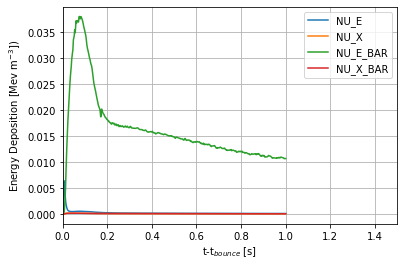

In [8]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 1.5))
ax.grid()

In [9]:
dt = 1*u.ms
trials = 10
distance = 10*u.kpc
frequency = 50*u.Hz # 50 Hz and 400 Hz, in steps of 50 Hz
smoothing = "mean"
smoothing_freq = 300*u.Hz
amplitude = 0.1 # 1% and 50% in log steps (1%, 2%, 5%, 10%, 20%, 50%)
t0 = 100*u.ms
t1 = 900*u.ms
position="center"

temp_char = {"frequency": frequency, 
             "amplitude": amplitude, #in percent of max value
             "t0": t0,
             "t1": t1,
             "position": position}

In [10]:
#average background given by the mean of the sensor distribution and scaled to the full detector
ba_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
ba_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

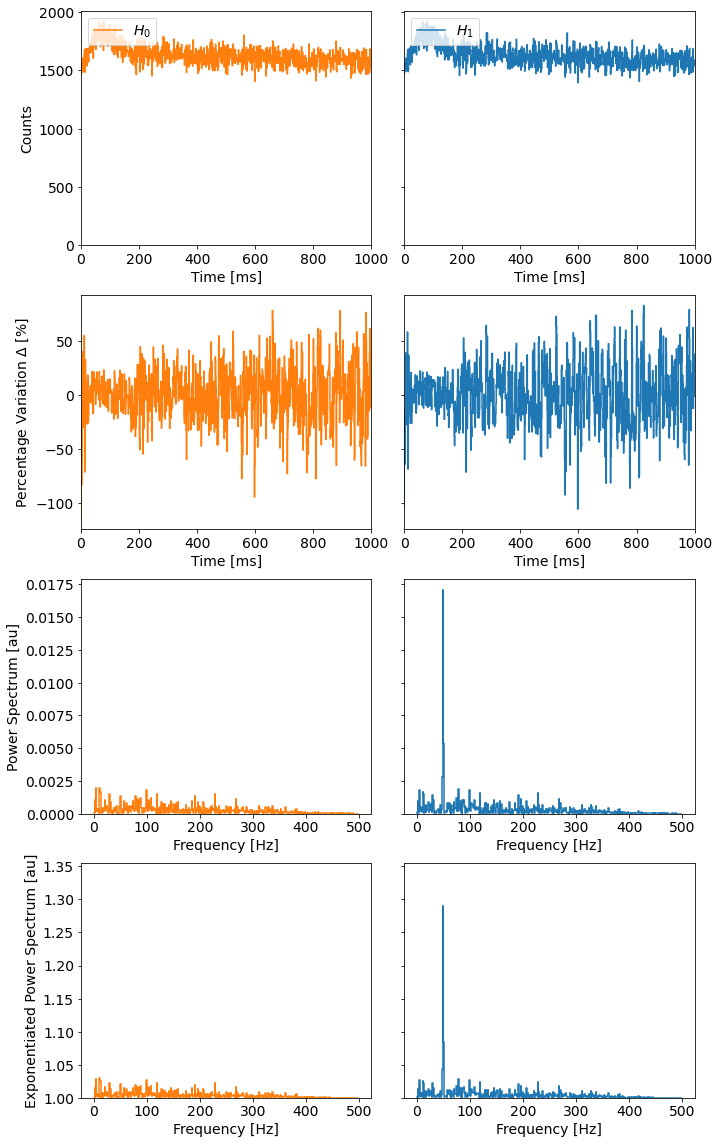

In [11]:
np.random.seed(0)

time_wind = [0, 1] * u.s # time independent
freq_wind = [0, 1E6] * u.Hz # freq independent

t, f, r, pd, p, bj  = signal_processing(sim, dt=dt, distance=distance, 
                                        temp_char=temp_char, trials=trials, residual=True, 
                                        smoothing=smoothing, smoothing_freq=smoothing_freq,
                                        return_pfbj=True, sig_method = 'none')

S_gen2, S_ic86, B_gen2, B_ic86 = r
Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = pd
Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = p
Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 = bj


Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = Spd_gen2*100, Spd_ic86*100, Bpd_gen2*100, Bpd_ic86*100

fig, ax = plt.subplots(4,2, figsize = (10,16), sharey='row')
ax = ax.ravel()

ax[0].step(t, B_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[0].set_xlabel('Time [ms]', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_xlim(0,1000)
ax[0].set_ylim(0,1.05*np.nanmax(S_ic86[0]))
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'upper left')
ax[1].step(t, S_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[1].set_xlabel('Time [ms]', fontsize = 14)
ax[1].set_xlim(0,1000)
ax[1].tick_params(labelsize = 14)
ax[1].legend(ncols = 2, fontsize = 14, loc = 'upper left')

ax[2].step(t, Bpd_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[2].set_xlabel('Time [ms]', fontsize = 14)
ax[2].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[2].set_xlim(0,1000)
#ax[2].set_ylim(-1,1)
ax[2].tick_params(labelsize = 14)
ax[3].step(t, Spd_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[3].set_xlabel('Time [ms]', fontsize = 14)
ax[3].set_xlim(0,1000)
ax[3].tick_params(labelsize = 14)

ax[4].step(f, Bp_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[4].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[4].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[4].set_ylim(0,1.05*np.nanmax(Sp_ic86[0]))
ax[4].tick_params(labelsize = 14)
ax[5].step(f, Sp_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[5].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[5].tick_params(labelsize = 14)

ax[6].step(f, Bbj_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[6].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[6].set_ylabel('Exponentiated Power Spectrum [au]', fontsize = 14)
ax[6].set_ylim(1,1.05*np.nanmax(Sbj_ic86[0]))
ax[6].tick_params(labelsize = 14)
ax[7].step(f, Sbj_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[7].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[7].tick_params(labelsize = 14)

#plt.savefig("../plots/ftf_bj_d={}kpc_reds.pdf".format(d), dpi = 200)
plt.tight_layout()

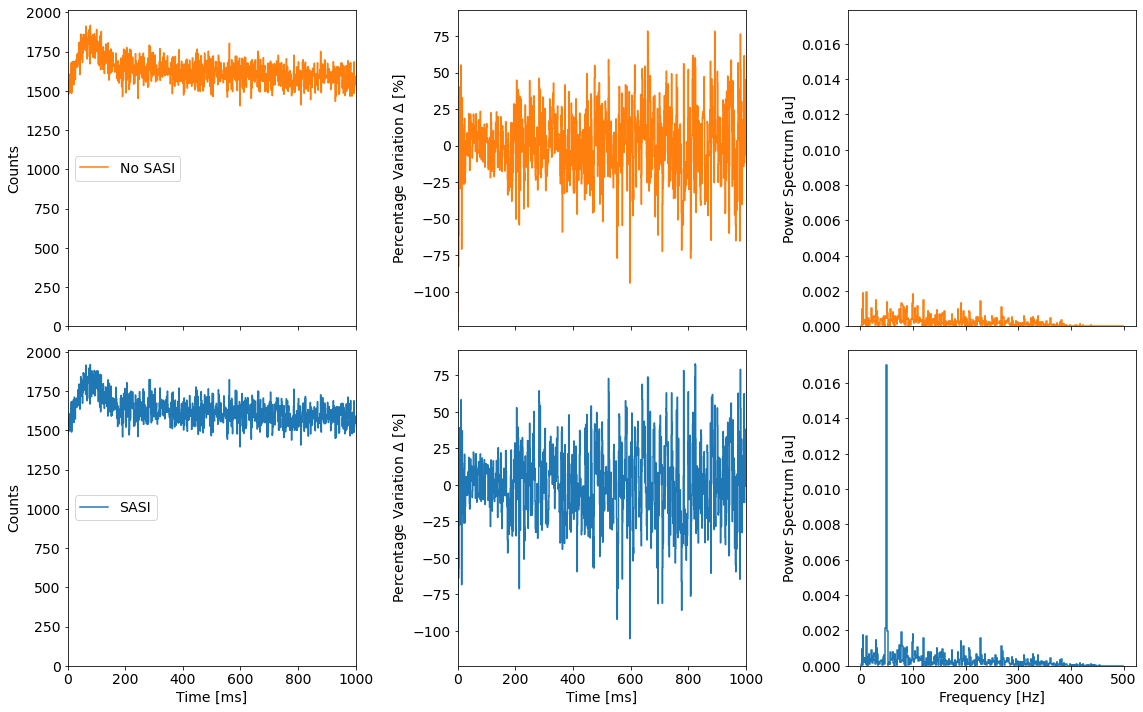

In [12]:
np.random.seed(0)

time_wind = [0, 1] * u.s # time independent
freq_wind = [0, 1E6] * u.Hz # freq independent

t, f, r, pd, p, bj  = signal_processing(sim, dt=dt, distance=distance, 
                                        temp_char=temp_char, trials=trials, residual=True, 
                                        smoothing=smoothing, smoothing_freq=smoothing_freq,
                                        return_pfbj=True, sig_method = 'none')

S_gen2, S_ic86, B_gen2, B_ic86 = r
Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = pd
Sp_gen2, Sp_ic86, Bp_gen2, Bp_ic86 = p
Sbj_gen2, Sbj_ic86, Bbj_gen2, Bbj_ic86 = bj


Spd_gen2, Spd_ic86, Bpd_gen2, Bpd_ic86 = Spd_gen2*100, Spd_ic86*100, Bpd_gen2*100, Bpd_ic86*100

fig, ax = plt.subplots(2,3, figsize = (16,10), sharex = "col", sharey = "col")
ax = ax.ravel()

ax[0].step(t, B_ic86[0], color = 'C1', ls = '-', label='No SASI', zorder = -10)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_xlim(0,1000)
ax[0].set_ylim(0,1.05*np.nanmax(S_ic86[0]))
ax[0].tick_params(labelsize = 14)
ax[0].legend(ncols = 2, fontsize = 14, loc = 'center left')
ax[3].step(t, S_ic86[0], color = 'C0',  ls = '-', label='SASI', zorder = -10)
ax[3].set_xlabel('Time [ms]', fontsize = 14)
ax[3].set_ylabel('Counts', fontsize = 14)
ax[3].set_xlim(0,1000)
ax[3].tick_params(labelsize = 14)
ax[3].legend(ncols = 2, fontsize = 14, loc = 'center left')

ax[1].step(t, Bpd_ic86[0], color = 'C1', ls = '-', label=r'$H_{0}$', zorder = -10)
ax[1].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[1].set_xlim(0,1000)
#ax[2].set_ylim(-1,1)
ax[1].tick_params(labelsize = 14)
ax[4].step(t, Spd_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = -10)
ax[4].set_xlabel('Time [ms]', fontsize = 14)
ax[4].set_ylabel('Percentage Variation $\Delta$ [%]', fontsize = 14)
ax[4].set_xlim(0,1000)
ax[4].tick_params(labelsize = 14)

ax[2].step(f, Bp_ic86[0], color = 'C1',  ls = '-', label=r'$H_{0}$', zorder = 10)
ax[2].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[2].set_ylim(0,1.05*np.nanmax(Sp_ic86[0]))
ax[2].tick_params(labelsize = 14)
ax[5].step(f, Sp_ic86[0], color = 'C0',  ls = '-', label=r'$H_{1}$', zorder = 10)
ax[5].set_xlabel('Frequency [Hz]', fontsize = 14)
ax[5].set_ylabel('Power Spectrum [au]', fontsize = 14)
ax[5].tick_params(labelsize = 14)


plt.tight_layout()

In [35]:
data = np.array([t.value,S_ic86[0]])
np.savetxt("generic_sasi_10kpc_50Hz_10perc.txt", data.T, header="Time [ms] Counts/bin")

array([1470.06944832, 1477.40678683, 1565.64713035, ..., 1558.21058012,
       1590.07467893, 1543.11852184])

In [113]:
t, sa_ic86, sa_gen2 = get_average_signal(sim, dt, frequency=20*u.Hz)

Text(0, 0.5, 'Counts/bin')

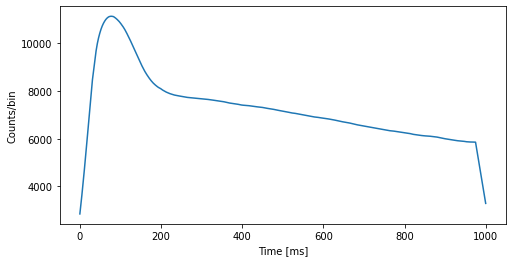

In [119]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(t, sa_ic86)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Counts/bin')

Text(0, 0.5, 'Counts/bin')

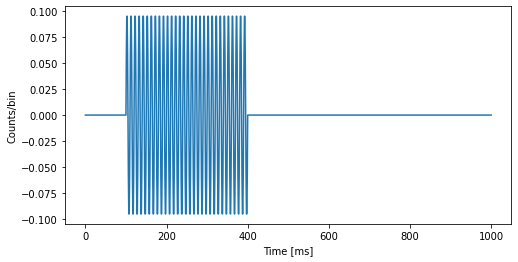

In [127]:
st_ic86 = get_template(sim, dt, 100*u.Hz, 0.1, t0, t1, position="center")

fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(t, st_ic86)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Counts/bin')

Text(0, 0.5, 'Counts/bin')

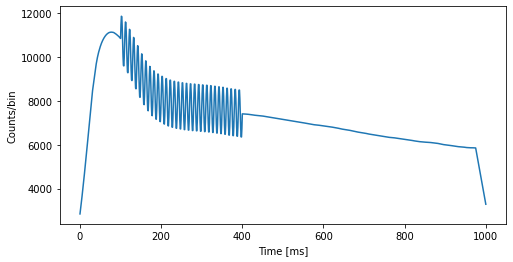

In [128]:
t, s_ic86, s_gen2 = get_generic_lc(sim, dt, temp_char)

fig, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(t, s_ic86)
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Counts/bin')

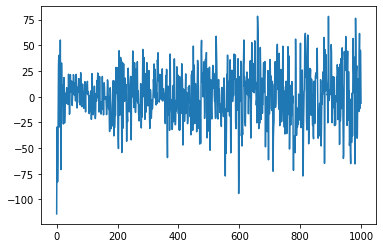

In [14]:
plt.plot(Bpd_ic86[0])

In [15]:
from sklearn.linear_model import Ridge

ModuleNotFoundError: No module named 'sklearn'